In [75]:
pip install chart-studio

     |████████████████████████████████| 64 kB 1.8 MB/s eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [78]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [3]:
PGAdat = pd.read_csv("../input/pga2019/2019_data.csv")
PGAdat

,Player Name,Date,Statistic,Variable,Value
0,Cameron Champ,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),78
1,Rory McIlroy,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),72
2,Luke List,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),66
3,Dustin Johnson,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),73
4,Wyndham Clark,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),87
...,...,...,...,...,...
9720524,Beau Hossler,2019-07-07,Fairway Bunker Tendency,Fairway Bunker Tendency - (RELATIVE TO PAR),+0.087
9720525,John Chin,2019-07-07,Fairway Bunker Tendency,Fairway Bunker Tendency - (RELATIVE TO PAR),+0.212
9720526,Matt Every,2019-07-07,Fairway Bunker Tendency,Fairway Bunker Tendency - (RELATIVE TO PAR),+0.485
9720527,Stewart Cink,2019-07-07,Fairway Bunker Tendency,Fairway Bunker Tendency - (RELATIVE TO PAR),+0.226


In [4]:
PGAdat = PGAdat.rename(columns={"Player Name": "player_name"})


In [5]:
PGAdat.Variable.unique()

array(['Driving Distance - (ROUNDS)', 'Driving Distance - (AVG.)',
       'Driving Distance - (TOTAL DISTANCE)', ...,
       'SG: Around-the-Green - (MEASURED ROUNDS)',
       'SG: Around-the-Green - (ROUNDS)',
       'SG: Around-the-Green - (TOTAL SG:ARG)'], dtype=object)

In [6]:
PGAdat.Variable.value_counts()

Official World Golf Ranking - (POINTS LOST)      30172
Official World Golf Ranking - (EVENTS)           30172
Official World Golf Ranking - (AVG POINTS)       30172
Official World Golf Ranking - (POINTS GAINED)    30172
Official World Golf Ranking - (TOTAL POINTS)     30172
                                                 ...  
Last 15 Events - Scoring - (EVENTS)                 33
Last 5 Events - Scoring - (EVENTS)                   6
Last 5 Events - Putting - (RATING)                   6
Last 5 Events - Putting - (EVENTS)                   6
Last 5 Events - Scoring - (RATING)                   6
Name: Variable, Length: 1496, dtype: int64



PGA Tour Information -

Initially, the information I got from the csv file did not combine all player names. Instead, it grouped by tournament and each player was repeated multiple times. My first thought was to merge csv rows by name, but that would've made a very wide dataframe that I am not particularly interested in pursuing.

Since I may want to leave the option open to do a time series throughout the year, a simple merging of all the cells according to statistical category won't work either. If I was searching through all historical data, I could do a time series of the averages of all players, but that doesn't make sense over the course of a single season.

Directly from the PGA Tour website, there are 379 unique players and 431 statistical categories--which are sometimes the identical statistic separated into RANK and AVERAGE for the week--for each individual player. (Other variables do exist, which I put below in the unique counter, but this is a simple example. They are mostly self-explanatory. If I use one, I will explain it.

An example of RANK and AVERAGE for a statistical category

Ex:

Driving Distance RANK THIS WEEK - 3 AVERAGE THIS WEEK - 279.2

The rank is how the golfer fared compared to the rest of the field. The average is the average of 2 drives per golfer taken over the course of the tournament. (At least, that was how the USGA measured it in 2019 https://www.usga.org/content/dam/usga/pdf/2020/distance-insights/ADDR-FINAL-2019-usga-distance.pdf )

Total, the number of individual statistics possible ends up being 163,349. Add on the number of tournaments(not every player plays in every tournament) and the data file ends up being just under 2 million rows. Of this large number, only 82 values are missing in my adjusted csv file. No individual statistic holds the most statistics missing, they tend to be spread out. While the csv file does not have a ton of missing rows, this is likely due to the PGA not including all players in the statistical categories at tournaments in which they didn't play. If the PGA input every possible player in every tournament (considering only players in good standing in the PGA) then the total row number would be ~ 7.5 million. That is a bigger hassle that I luckily don't have to deal with in this circumstance.

As a sidenote, this lack of missing variables is one of the benefits of a sport like golf. Due to the nature of the sport, measurements are able to be precise. Missing variables are typically from equipment malfunction or an increase in speed of play. Only other time missing variables occur is due to injury or any other freak incident which causes a break in the middle of a round.

RANK will not have any outliers. I will likely use it only for comparison purposes if I use the statistic much at all.

My focus on the remaining 42 different types--under the category variable for this


Text(0, 0.5, 'Season')

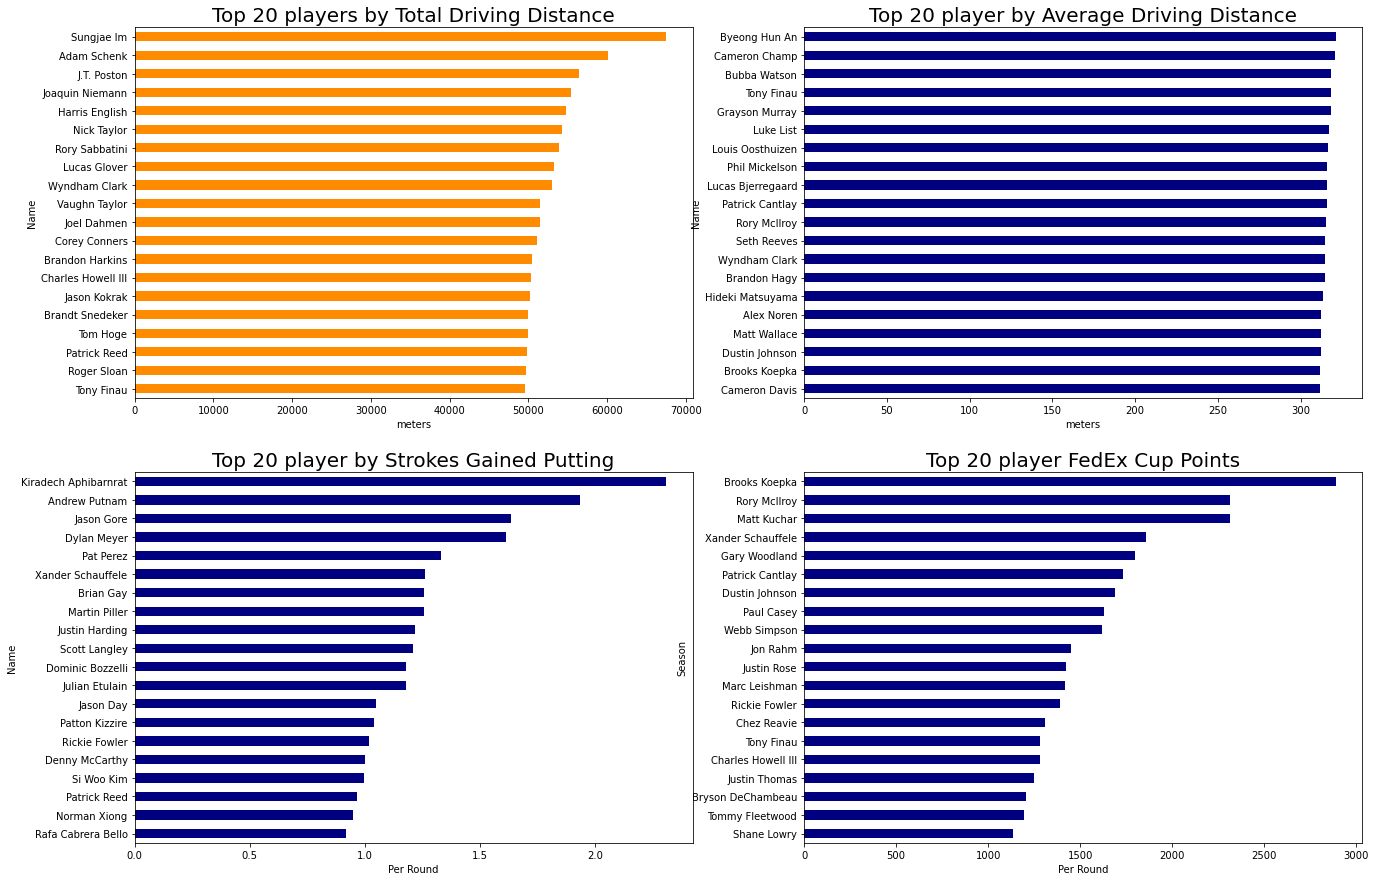

In [7]:
DriDist=PGAdat[PGAdat.Variable=='Driving Distance - (TOTAL DISTANCE)'].iloc[:,[0,4]]
DriDist['Value_new']=DriDist['Value'].apply(lambda x:''.join(x.split(',')))
DriDist.Value_new=DriDist.Value_new.astype(int)
DriDist=DriDist.drop(columns='Value')
plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
DriDist.groupby('player_name')['Value_new'].max().sort_values(ascending=False)[:20].sort_values().plot.barh(color='orange')
plt.title("Top 20 players by Total Driving Distance",size=20)
plt.xlabel('meters')
plt.ylabel('Name')

plt.subplot(2,2,2)
DriDistAvg=PGAdat[PGAdat.Variable=='Driving Distance - (AVG.)'].iloc[:,[0,4]]
DriDistAvg.Value=DriDistAvg.Value.astype(float)
DriDistAvg.groupby('player_name')['Value'].max().sort_values(ascending=False)[:20].sort_values().plot.barh(color='blue')
plt.title("Top 20 player by Average Driving Distance",size=20)
plt.xlabel('meters')
plt.ylabel('Name')

plt.subplot(2,2,3)
SGPutt=PGAdat[PGAdat.Variable=='SG: Putting - (AVERAGE)'].iloc[:,[0,4]]
SGPutt.Value=SGPutt.Value.astype(float)
SGPutt.groupby('player_name')['Value'].max().sort_values(ascending=False)[:20].sort_values().plot.barh(color='green')
plt.title("Top 20 player by Strokes Gained Putting",size=20)
plt.xlabel('Per Round')
plt.ylabel('Name')




plt.subplot(2,2,4)
FedEx=PGAdat[PGAdat.Variable=='FedExCup Season Points - (POINTS)'].iloc[:,[0,4]]
FedEx.Value=FedEx.Value.astype(str).apply(lambda x:''.join(x.split(','))).astype(int)
FedEx.groupby('player_name')['Value'].max().sort_values(ascending=False)[:20].sort_values().plot.barh(color='red')
plt.title("Top 20 player FedEx Cup Points",size=20)
plt.xlabel('Per Round')
plt.ylabel('Season')



RANK THIS WEEK and AVG take up the vast majority of the statistics. Due to the nature of averages, and that the rest are percentages, I have no plans to remove outliers in the data. I could be swayed, but that'll come later. I don't currently plan to search through MONEY, LOW RND or BEST STREAK which would be the most likely to have issues with outliers. Therefore, I'm leaving outlier prone statistics alone for now.

My plan is to take the average per week RANK of driving distance and the average of per week RANK of SG to see if anyone is in the top 10 or more over the season and which seems to be more important. SG is strokes gained, which can be a slightly confusing metric for anyone not accustomed to it. Essentially, it measures averages of other players against the desired player and gives them a +/- score (a + means you gained against the field, - means you lost against the field). More info can be found https://www.pgatour.com/news/2016/05/31/strokes-gained-defined.html


The top 20 in Average Driving Distance & Strokes Gained: Putting don't have anyone in common. Comparing these two between my main metric--which is FedExCup Points--there seems to be a bit more correlation between average Driving Distance than SG: Putting.

The following players are in the top 20 with Avg. Driving Distance and FedExCup Pts.
1) Tony Finau
2) Patrick Cantlay
3) Dustin Johnson
4) Rory McIlroy
5) Brooks Koepka



Following players are in the top 20 with SG: Putting and FedExCup Pts.
1) Xander Schauffele


From first glance, it looks like there is much more correlation between Avg. Driving Distance and FedExCup Pts than between SG: Putting. This is maybe a little odd, as the short game is where you actually score points, but I'll confirm with a heatmap below.




The FedEx Cup is a relatively new PGA tournament added to the golf season. Based on finishes, you will receive a certain amount of points based on strength of field, course slope rating (this is a rating of difficulty, the higher the slope the more difficult the course. Many public courses hover between 110-120. A professional level course is typically 150+). The winner of the FedEx Cup wins $10 million. Because of the combination of things, there is no reason to ignore it for EDA.



It looks like the only one who was on both of those lists is Gary Woodland. In further analysis, I will look into what other variables may better predict total FedEx points and start fitting models to the data. Perhaps beyond the scope of this course, I will use this data and attempt to use it as training data against the stats from other years and see if I can make a predictive model.


In [55]:
colUpdate = ['player_name', 'Date', 'Driving Distance - (TOTAL DISTANCE)','FedExCup Season Points - (POINTS)', 'Driving Distance - (AVG.)', 'SG: Putting - (AVERAGE)', 'GIR Percentage - 100+ yards - (%)']

In [56]:
PGAdatcol = PGAdat.set_index(['player_name', 'Variable', 'Date'])['Value'].unstack('Variable').reset_index()
PGAdatcol = PGAdatcol[colUpdate].dropna()

In [57]:
PGAdatcol.head()

Variable,player_name,Date,Driving Distance - (TOTAL DISTANCE),FedExCup Season Points - (POINTS),Driving Distance - (AVG.),SG: Putting - (AVERAGE),GIR Percentage - 100+ yards - (%)
31,Aaron Baddeley,2019-01-27,"8,048",149,287.4,.191,72.08
32,Aaron Baddeley,2019-02-03,"9,262",149,289.4,.319,71.43
33,Aaron Baddeley,2019-02-10,"10,894",149,286.7,.141,71.57
34,Aaron Baddeley,2019-02-17,"13,206",158,287.1,.345,65.88
35,Aaron Baddeley,2019-02-24,"15,497",262,287.0,.345,65.88


In [62]:
PGAdatcol['Driving Distance - (TOTAL DISTANCE)']= PGAdatcol['Driving Distance - (TOTAL DISTANCE)'].str.replace(',','')
PGAdatcol['FedExCup Season Points - (POINTS)']= PGAdatcol['FedExCup Season Points - (POINTS)'].str.replace(',','')

In [63]:
for col in  PGAdatcol.columns[3:]:
   PGAdatcol[col] = PGAdatcol[col].astype(float)
PGAdatcol

Variable,player_name,Date,Driving Distance - (TOTAL DISTANCE),FedExCup Season Points - (POINTS),Driving Distance - (AVG.),SG: Putting - (AVERAGE),GIR Percentage - 100+ yards - (%)
31,Aaron Baddeley,2019-01-27,8048,149.0,287.4,0.191,72.08
32,Aaron Baddeley,2019-02-03,9262,149.0,289.4,0.319,71.43
33,Aaron Baddeley,2019-02-10,10894,149.0,286.7,0.141,71.57
34,Aaron Baddeley,2019-02-17,13206,158.0,287.1,0.345,65.88
35,Aaron Baddeley,2019-02-24,15497,262.0,287.0,0.345,65.88
...,...,...,...,...,...,...,...
35661,Zach Johnson,2019-07-28,34427,270.0,286.9,-0.040,57.48
35662,Zach Johnson,2019-08-04,36799,276.0,287.5,-0.087,58.99
35663,Zach Johnson,2019-08-11,36799,276.0,287.5,-0.087,58.99
35664,Zach Johnson,2019-08-18,36799,276.0,287.5,-0.087,58.99


In [65]:
corr = PGAdatcol.corr(method='pearson')

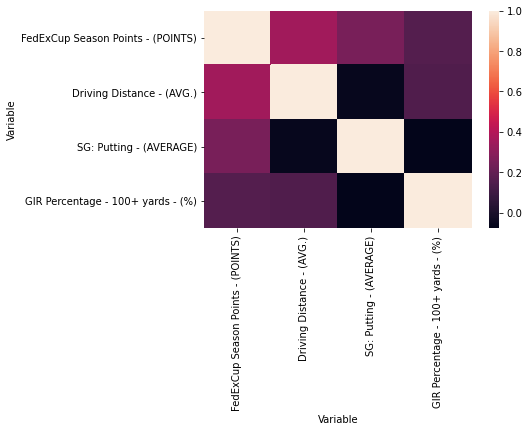

In [66]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [97]:
PGAdatcol[['FedExCup Season Points - (POINTS)', 'Driving Distance - (AVG.)', 'player_name', 'Date']].iplot(
    y='FedExCup Season Points - (POINTS)', mode='lines+markers',xTitle='Driving Distance - (AVG.)', yTitle='FedExCup Pts',
    text='player_name', title='Driving Distance & FedEx Cup Points')

In [90]:
PGAdatcol['Date']

31       2019-01-27
32       2019-02-03
33       2019-02-10
34       2019-02-17
35       2019-02-24
            ...    
35661    2019-07-28
35662    2019-08-04
35663    2019-08-11
35664    2019-08-18
35665    2019-08-25
Name: Date, Length: 6100, dtype: object